In [1]:
import tqdm, torch, json, pickle, os, gc, time
import pandas as pd
import numpy as np
from collections import OrderedDict
from src.utils.dataset import FPolyDatasetV2, collate_fn
from src.utils.data import CrossValidation
from src.utils.visualization import plot_scatter
from torch_geometric.nn import global_add_pool, global_max_pool, global_mean_pool
import xgboost as xgb
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from bayes_opt import BayesianOptimization
import seaborn as sns
from pathlib import Path


/home/jhyang/anaconda3/envs/poly/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [3]:
train_ds = FPolyDatasetV2()#blacklist=json.load(open('./data/blacklist.json')))
train_ds.generate('./data/fpolymers_230823.tg.train.csv')
test_ds = FPolyDatasetV2()#blacklist=json.load(open('./data/blacklist.json')))
test_ds.generate('./data/fpolymers_230823.tg.test.csv')
cv = CrossValidation(n_fold=5, n_data=len(train_ds), return_index=True)

  Overwriting attribute : norm
  Overwriting attribute : data
  Overwriting attribute : atom_feat_name
  Overwriting attribute : bond_feat_name
  Overwriting attribute : mol_feat_name
  Overwriting attribute : target_desc
  Overwriting attribute : tag
  Overwriting attribute : cache_fn
  Setting new attribute : unique_data
  Overwriting attribute : norm
  Overwriting attribute : blacklist
  Overwriting attribute : data
  Overwriting attribute : atom_feat_name
  Overwriting attribute : bond_feat_name
  Overwriting attribute : mol_feat_name
  Overwriting attribute : target_desc
  Overwriting attribute : tag
  Overwriting attribute : cache_fn
  Setting new attribute : unique_data


In [5]:
def vector_from_atom_feat(dataset, index=None):
    if index is None:
        feat, tgt, ids = collate_fn(dataset, 'cpu')
    else:
        feat, tgt, ids = collate_fn(dataset[index], 'cpu')
    
    fs = []
    for f in feat:
        b = f['data_idx']
        w = f['weight']
        h = global_mean_pool(f['atom_feat'], f['graph_idx'])
        fs.append(
            global_mean_pool(torch.hstack([h * w, h]), b).numpy()
        )
    f = np.sum(fs, axis=0)
    return f, tgt.numpy(), ids

def vector_from_mol_feat(dataset, index=None):
    if index is None:
        feat, tgt, ids = collate_fn(dataset, 'cpu')
    else:
        feat, tgt, ids = collate_fn(dataset[index], 'cpu')
    
    fs = []
    for f in feat:
        b = f['data_idx']
        w = f['weight']
        h = f['mol_feat']
        fs.append(
            global_mean_pool(torch.hstack([h * w, h]), b).numpy()
        )
    f = np.sum(fs, axis=0)
    return f, tgt.numpy(), ids

def xgb_obj_fnc(eta, max_depth):
    global train_data, valid_data, test_data, m_best, best
    params = {
        'max_depth':int(np.round(max_depth)),
        'min_child_weight': 1,
        'eta':eta,
        # Other parameters
        'objective':'reg:squarederror',
        'eval_metric':'mae'
    }
    booster = xgb.train(params, dtrain=train_data, num_boost_round=50, early_stopping_rounds=5, 
                        evals=[(valid_data, 'valid')], verbose_eval=False)
    tt = train_data.get_label()
    vt = valid_data.get_label()
    tp = booster.predict(train_data, iteration_range=(0, booster.best_iteration+1))
    vp = booster.predict(valid_data, iteration_range=(0, booster.best_iteration+1))
    train_r2, train_mae = r2_score(tt, tp), mean_absolute_error(tt, tp)
    valid_r2, valid_mae = r2_score(vt, vp), mean_absolute_error(vt, vp)
    m = train_r2 + valid_r2 - 0.02 * (train_mae + valid_mae)
    if m > m_best:
        ft = test_data.get_label()
        fp = booster.predict(test_data, iteration_range=(0, booster.best_iteration+1))
        m_best = m
        best = {'params':params, 'train':[tt, tp], 'valid':[vt, vp], 'test':[ft, fp]}
    return m

In [6]:
train_af, train_tgt, train_ids = vector_from_atom_feat(train_ds)
test_af, test_tgt, test_ids = vector_from_atom_feat(test_ds)

train_mf, train_tgt, train_ids = vector_from_mol_feat(train_ds)
test_mf, test_tgt, test_ids = vector_from_mol_feat(test_ds)

features = {
    'graph':[train_af, test_af],
    'global':[train_mf, test_mf],
    'both':[np.hstack([train_af, train_mf]), np.hstack([test_af, test_mf])],
}

In [5]:
outputs = {}
for i in range(5):
    output = {}
    train_idx, valid_idx = cv[i]
    for feature_type, (train_feat, test_feat) in features.items():
        train_data = xgb.DMatrix(train_feat[train_idx], train_tgt[train_idx])
        valid_data = xgb.DMatrix(train_feat[valid_idx], train_tgt[valid_idx])
        test_data = xgb.DMatrix(test_feat, test_tgt)
        m_best = -1e5
        bo = BayesianOptimization(obj_fnc, pbounds={'eta':[1e-2,1], 'max_depth':[1,20]},
                                  random_state=100, verbose=0)
        bo.maximize(init_points=10, n_iter=140)
        tt, tp = best['train']
        vt, vp = best['valid']
        ft, fp = best['test']
        vals = [
            r2_score(tt, tp), np.sqrt(mean_squared_error(tt, tp)), mean_absolute_error(tt, tp),
            r2_score(vt, vp), np.sqrt(mean_squared_error(vt, vp)), mean_absolute_error(vt, vp),
            r2_score(ft, fp), np.sqrt(mean_squared_error(ft, fp)), mean_absolute_error(ft, fp)
        ]
        print('Fold: {} : {:7.3f} / {:5.2f} / {:5.2f} | {:7.3f} / {:5.2f} / {:5.2f} | {:7.3f} / {:5.2f} / {:5.2f} | '.format(i, *vals))
        output[feature_type] = best.copy(), vals
    outputs[i] = output
#    print('-'*70)
#    print('AVG:     : {:7.3f} / {:5.2f} / {:5.2f} | {:7.3f} / {:5.2f} / {:5.2f} | {:7.3f} / {:5.2f} / {:5.2f} | '.format(*np.mean(vals, axis=0)))
#    print('STD:     : {:7.3f} / {:5.2f} / {:5.2f} | {:7.3f} / {:5.2f} / {:5.2f} | {:7.3f} / {:5.2f} / {:5.2f} | '.format(*np.std(vals, axis=0)))


Fold: 0 :   0.983 /  3.90 /  2.72 |   0.564 / 21.45 / 13.83 |  -1.047 / 24.56 / 18.98 | 
Fold: 0 :   1.000 /  0.06 /  0.02 |   0.607 / 20.36 / 14.86 |  -1.203 / 25.47 / 19.34 | 
Fold: 0 :   1.000 /  0.00 /  0.00 |   0.660 / 18.95 / 12.12 |  -0.414 / 20.41 / 16.00 | 
Fold: 1 :   0.990 /  2.95 /  0.70 |   0.500 / 23.15 / 15.71 |  -1.186 / 25.38 / 20.76 | 
Fold: 1 :   1.000 /  0.02 /  0.01 |   0.720 / 17.32 / 13.70 |  -0.455 / 20.70 / 16.77 | 
Fold: 1 :   1.000 /  0.45 /  0.22 |   0.789 / 15.04 / 12.20 |  -0.550 / 21.37 / 17.01 | 
Fold: 2 :   0.977 /  4.60 /  2.87 |   0.254 / 28.39 / 22.03 |  -1.215 / 25.54 / 20.45 | 
Fold: 2 :   1.000 /  0.27 /  0.12 |   0.563 / 21.74 / 17.34 |  -0.422 / 20.47 / 14.79 | 
Fold: 2 :   0.998 /  1.23 /  0.76 |   0.584 / 21.19 / 17.18 |  -0.435 / 20.56 / 15.01 | 
Fold: 3 :   0.988 /  3.48 /  0.74 |   0.250 / 24.13 / 17.26 |  -1.062 / 24.64 / 18.79 | 
Fold: 3 :   1.000 /  0.10 /  0.04 |   0.557 / 18.55 / 13.60 |  -0.691 / 22.32 / 16.74 | 
Fold: 3 :   1.000 /  

In [6]:
with open('xgb.output.231016b.pkl','wb') as f:
    pickle.dump(outputs, f)

In [7]:
import pickle
import numpy as np
with open('xgb.output.231016b.pkl','rb') as f:
    outb = pickle.load(f)
with open('xgb.output.231016.pkl','rb') as f:
    out = pickle.load(f)

In [58]:
mapper = {0:'graph',1:'global',2:'both'}
best_output = [vv[mapper[np.argmax([v[1][3] for v in vv.values()])]] for vv in out.values()]
for vals in np.array([v[1] for v in best_output]):
    print('{:7.3f}  {:7.3f} / {:7.3f} {:7.3f} / {:7.3f} {:7.3f}'.format(*vals[[0,2,3,5,6,8]]))
print('-'*80)
print('{:7.3f}  {:7.3f} / {:7.3f} {:7.3f} / {:7.3f} {:7.3f}'.format(*np.array([v[1] for v in best_output]).mean(0)[[0,2,3,5,6,8]]))
print('{:7.3f}  {:7.3f} / {:7.3f} {:7.3f} / {:7.3f} {:7.3f}'.format(*np.array([v[1] for v in best_output]).std(0)[[0,2,3,5,6,8]]))
print('-'*80)

x1 = np.hstack([v[0]['valid'][0] for v in best_output])
y1 = np.hstack([v[0]['valid'][1] for v in best_output])
x2 = test_tgt
y2 = np.mean([v[0]['test'][1] for v in best_output], 0)
print('{:7s}  {:7s} / {:7.3f} {:7.3f} / {:7.3f} {:7.3f}'.format('','',r2_score(x1, y1), mean_absolute_error(x1, y1), r2_score(x2, y2), mean_absolute_error(x2,y2)))



  0.999    0.689 /   0.628  14.624 /  -0.450  15.299
  0.979    3.234 /   0.683  12.933 /  -0.355  15.523
  1.000    0.307 /   0.745  12.093 /  -0.474  16.010
  0.992    2.169 /   0.546  14.188 /  -0.507  16.021
  0.994    1.703 /   0.734   9.942 /  -0.211  15.059
--------------------------------------------------------------------------------
  0.993    1.620 /   0.667  12.756 /  -0.399  15.582
  0.007    1.049 /   0.073   1.669 /   0.107   0.383
--------------------------------------------------------------------------------
                 /   0.681  12.756 /  -0.242  14.989


In [59]:
[v[0]['params'] for v in best_output]

[{'max_depth': 6,
  'min_child_weight': 1,
  'eta': 0.20025794323602905,
  'objective': 'reg:squarederror',
  'eval_metric': 'mae'},
 {'max_depth': 3,
  'min_child_weight': 1,
  'eta': 0.16332906598976704,
  'objective': 'reg:squarederror',
  'eval_metric': 'mae'},
 {'max_depth': 7,
  'min_child_weight': 1,
  'eta': 0.5381005031877998,
  'objective': 'reg:squarederror',
  'eval_metric': 'mae'},
 {'max_depth': 3,
  'min_child_weight': 1,
  'eta': 0.3850956834259727,
  'objective': 'reg:squarederror',
  'eval_metric': 'mae'},
 {'max_depth': 4,
  'min_child_weight': 1,
  'eta': 0.18264340397649573,
  'objective': 'reg:squarederror',
  'eval_metric': 'mae'}]

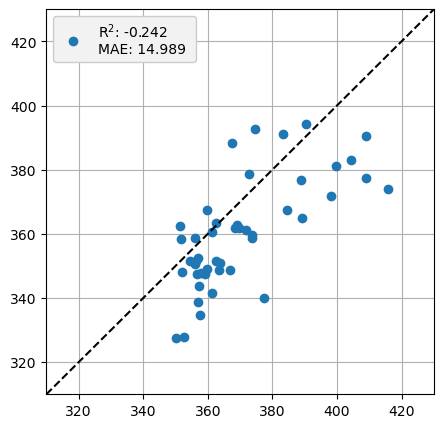

In [13]:
f, ax = plt.subplots(1,1,figsize=(5,5))
plot_scatter(ax, test_tgt.reshape(-1) + 273.15,  np.mean([v[0]['test'][1] for v in best_output], 0) + 273.15, xrange = [310, 430], fmts=['{:5.3f}','{:5.3f}'], metrics=['R2','MAE'])
f.savefig('./figs/output.xgb.test.pdf')

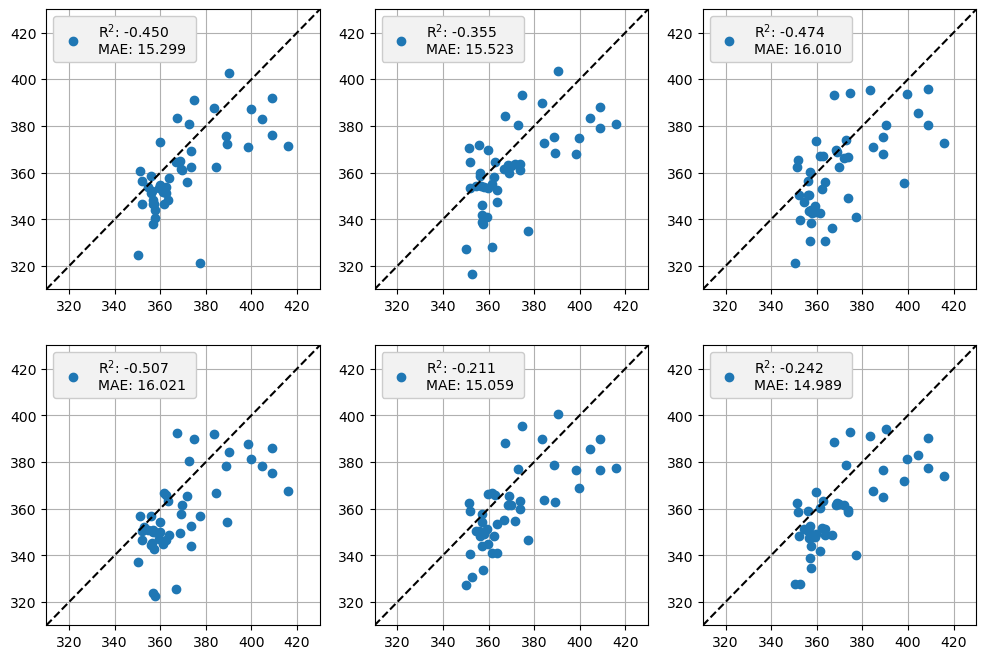

In [109]:
f, axs = plt.subplots(2,3,figsize=(12,8))
for i, ax in enumerate(axs.reshape(-1)[:5]):
    plot_scatter(ax, test_tgt.reshape(-1) + 273.15,  best_output[i][0]['test'][1] + 273.15, xrange = [310, 430], fmts=['{:5.3f}','{:5.3f}'], metrics=['R2','MAE'])
plot_scatter(axs[-1,-1], test_tgt.reshape(-1) + 273.15, np.mean([v[0]['test'][1] for v in best_output], 0) + 273.15, xrange= [310,430], fmts=['{:5.3f}','{:5.3f}'], metrics=['R2','MAE'])
f.savefig('./figs/output.xgb.test.all.pdf')
#plot_scatter(ax, test_tgt.reshape(-1) + 273.15,  np.mean([v[0]['test'][1] for v in best_output], 0) + 273.15, xrange = [310, 430])
#f.savefig('./output.xgb.models.pdf')

- SVR

In [71]:
from sklearn.svm import SVR

def svr_obj_fnc(coef, c, eps):
    global kernel, x_train, x_valid, y_train, y_valid, x_test, test_tgt, m_best, best
    params = {'coef0':coef, 'C':c, 'epsilon':eps}
    svr = SVR(kernel=kernel, **params)
    svr.fit(x_train, y_train.reshape(-1))
    tp = svr.predict(x_train)
    vp = svr.predict(x_valid)
    train_r2, train_mae = r2_score(y_train, tp), mean_absolute_error(y_train, tp)
    valid_r2, valid_mae = r2_score(y_valid, vp), mean_absolute_error(y_valid, vp)
    m = train_r2 + valid_r2 - 0.02 * (train_mae + valid_mae)
    if m > m_best:
        m_best = m
        fp = svr.predict(x_test)
        test_r2, test_mae = r2_score(test_tgt, fp), mean_absolute_error(test_tgt, fp)
        train_rmse = np.sqrt(mean_squared_error(y_train, tp))
        valid_rmse = np.sqrt(mean_squared_error(y_valid, vp))
        test_rmse = np.sqrt(mean_squared_error(test_tgt, fp))
        best = {'params':params, 'train':[y_train, tp], 'valid':[y_valid, vp], 'test':[test_tgt, fp], 
                'measure':[train_r2, train_rmse, train_mae, valid_r2, valid_rmse, valid_mae, test_r2,  test_rmse, test_mae]}
        print('{:10s} | {:10s} | {:7.3f} | {:7.3f} / {:7.3f} | {:7.3f} / {:7.3f} | {:7.3f} / {:7.3f}'.format(ftyp, kernel, m_best, train_r2, train_mae, valid_r2, valid_mae, test_r2, test_mae), end='\r')
    return m

outputs_svr = {}
for i in range(5):
    m_best = -50
    train_idx, valid_idx = cv[i]
    for ftyp, (feat, x_test) in features.items():
        x_train = feat[train_idx]
        x_valid = feat[valid_idx]
        y_train = train_tgt[train_idx]
        y_valid = train_tgt[valid_idx]
        for kernel in ['linear', 'rbf']:
            bo = BayesianOptimization(svr_obj_fnc, pbounds={'coef':[0,0], 'c':[0.1,100], 'eps':[1e-3,10]},
                                      random_state=100, verbose=0, allow_duplicate_points=True)
            bo.maximize(init_points=10, n_iter=290)
        for kernel in ['poly', 'sigmoid']:
            bo = BayesianOptimization(svr_obj_fnc, pbounds={'coef':[0,10], 'c':[0.1,100], 'eps':[1e-3,10]},
                                      random_state=100, verbose=0, allow_duplicate_points=True)
            bo.maximize(init_points=10, n_iter=290)
    print('Fold: {} : {:7.3f} / {:7.3f} / {:7.3f} | {:7.3f} / {:7.3f} / {:7.3f} | {:7.3f} / {:7.3f} / {:7.3f} | '.format(i, *best['measure']))
    outputs_svr[i] = best.copy()

Data point [1.e+02 0.e+00 1.e-03] is not unique. 1 duplicates registered. Continuing ...
Data point [1.e+02 0.e+00 1.e-03] is not unique. 2 duplicates registered. Continuing ...
Data point [1.e+02 0.e+00 1.e-03] is not unique. 3 duplicates registered. Continuing ...
Data point [1.e+02 0.e+00 1.e-03] is not unique. 4 duplicates registered. Continuing ...
Data point [1.e+02 0.e+00 1.e-03] is not unique. 5 duplicates registered. Continuing ...
Data point [1.e+02 0.e+00 1.e-03] is not unique. 6 duplicates registered. Continuing ...
Data point [1.e+02 0.e+00 1.e-03] is not unique. 7 duplicates registered. Continuing ...
Data point [1.e+02 0.e+00 1.e-03] is not unique. 8 duplicates registered. Continuing ...
Data point [1.e+02 0.e+00 1.e-03] is not unique. 9 duplicates registered. Continuing ...
Data point [1.e+02 0.e+00 1.e-03] is not unique. 10 duplicates registered. Continuing ...
Data point [1.e+02 0.e+00 1.e-03] is not unique. 11 duplicates registered. Continuing ...
Data point [1.e+02 

In [78]:
with open('svr.output.231103.pkl','wb') as f:
    pickle.dump(outputs_svr, f)

array([[ 0.81728965, 13.32820302,  8.03241126,  0.6203304 , 17.78614504,
        13.18934182, -0.10633167, 18.05179498, 12.47682593],
       [ 0.77624225, 14.62104823,  8.27701554,  0.70874528, 15.99292079,
        11.99432062, -0.35051557, 19.94470048, 14.01722667],
       [ 0.77387953, 14.14368244,  8.96835898,  0.59044583, 22.15349937,
        15.48163693, -0.07013493, 17.75403165, 11.90181149],
       [ 0.80874983, 13.75347676,  9.34668056,  0.65054743, 16.52585269,
        11.46144776, -0.18798897, 18.70612897, 13.62174734],
       [ 0.81721942, 13.07461121,  7.8054353 ,  0.63604065, 19.03323339,
        14.16244309, -0.22155658, 18.9685666 , 13.54831689]])

In [105]:
mapper = {0:'graph',1:'global',2:'both'}
for vals in outputs_svr.values():
    print('{:7.3f}  {:7.3f} / {:7.3f} {:7.3f} / {:7.3f} {:7.3f}'.format(*np.array(vals['measure'])[[0,2,3,5,6,8]]))
print('-'*80)
print('{:7.3f}  {:7.3f} / {:7.3f} {:7.3f} / {:7.3f} {:7.3f}'.format(*np.array([v['measure'] for v in outputs_svr.values()]).mean(0)[[0,2,3,5,6,8]]))
print('{:7.3f}  {:7.3f} / {:7.3f} {:7.3f} / {:7.3f} {:7.3f}'.format(*np.array([v['measure'] for v in outputs_svr.values()]).std(0)[[0,2,3,5,6,8]]))
print('-'*80)

x1 = np.hstack([v['valid'][0].reshape(-1) for v in outputs_svr.values()])
y1 = np.hstack([v['valid'][1].reshape(-1) for v in outputs_svr.values()])
x2 = outputs_svr[0]['test'][0].reshape(-1)
y2 = np.mean([v['test'][1].reshape(-1) for v in outputs_svr.values()], 0)
print('{:7s}  {:7s} / {:7.3f} {:7.3f} / {:7.3f} {:7.3f}'.format('','',r2_score(x1, y1), mean_absolute_error(x1, y1), r2_score(x2, y2), mean_absolute_error(x2,y2)))



  0.817    8.032 /   0.620  13.189 /  -0.106  12.477
  0.776    8.277 /   0.709  11.994 /  -0.351  14.017
  0.774    8.968 /   0.590  15.482 /  -0.070  11.902
  0.809    9.347 /   0.651  11.461 /  -0.188  13.622
  0.817    7.805 /   0.636  14.162 /  -0.222  13.548
--------------------------------------------------------------------------------
  0.799    8.486 /   0.641  13.258 /  -0.187  13.113
  0.020    0.581 /   0.039   1.455 /   0.098   0.792
--------------------------------------------------------------------------------
                 /   0.642  13.258 /  -0.053  12.588


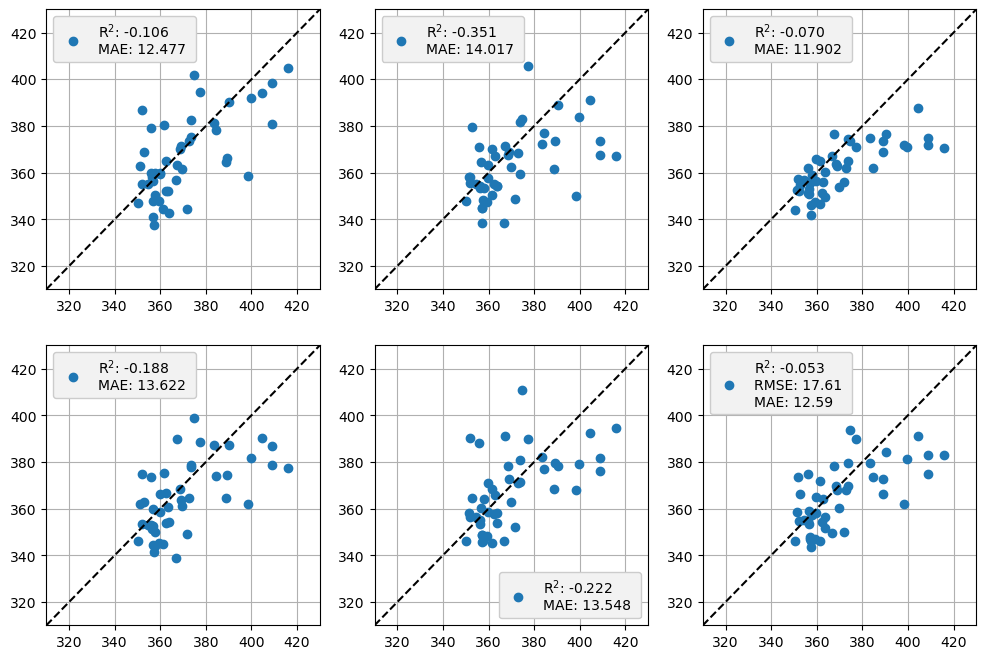

In [111]:
f, axs = plt.subplots(2,3,figsize=(12,8))
for i, ax in enumerate(axs.reshape(-1)[:5]):
    plot_scatter(ax, test_tgt.reshape(-1) + 273.15,  outputs_svr[i]['test'][1].reshape(-1)+273.15, xrange = [310, 430], fmts=['{:5.3f}','{:5.3f}'], metrics=['R2','MAE'])

plot_scatter(axs[-1,-1], x2 + 273.15,  y2 + 273.15, xrange = [310, 430])
f.savefig('./figs/output.svr.test.all.pdf')